<a href="https://colab.research.google.com/github/ratral/colab_control_valves/blob/master/cValvesCurator_02.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 1.- Installing an R Packages and functions.

_Read libraries_

In [ ]:
requiredPackages <- c( "tidyverse", "here", "devtools", "scales", 
                       "gridExtra", "knitr","kableExtra", "IRdisplay", 
                       "latex2exp")

  for(p in requiredPackages){
    if(!require( p, character.only = TRUE)) install.packages(p)
    library( p, character.only = TRUE)
  }

_Read needed functions_

In [14]:
  devtools::install_github("ratral/wcontrolvalve")

  # Define plot functions
  # CALCULATION Valve factors
    valve_parameters <- function(valve, dn, d1, d2){
      valve <- valve %>% 
        mutate( kvs  = wcontrolvalve::kv_value(dn, zvs)) %>% 
        mutate( fps  = wcontrolvalve::fp(kvs, dn, d1, d2)) %>% 
        mutate( flps = wcontrolvalve::flp(kvs, fls, dn, d1, d2)) %>% 
        mutate( flps_fps = flps/fps) %>% 
        select( name, kv_b, kv_d, kv_e, kvs, zvs,  fls, fps, flps, flps_fps)
      return(valve)
    }

    # CALCULATION of Base Data
    calc_base_data <- function(base_data){
      base_data <- base_data %>% 
                   mutate( dp = (p1 - p2), 
                           kv = wcontrolvalve::kv(p1, p2, flow, temp)) %>% 
                   mutate( zeta  = wcontrolvalve::zeta_vaule(dn, kv),
                           sig_1 = wcontrolvalve::sigma_1(p1, p2, elev, temp),
                           sig_2 = wcontrolvalve::sigma_2(p1, p2, flow/3600, dn, elev, temp)) 
      }

    # CALCULATION of the data analyse
    calc_data_analyse <- function(base_data, valve){
      data_analyse <- valve %>% 
                      mutate(data = list(base_data)) %>% unnest(data) %>% 
                      mutate(kv_kvs = ifelse(kv > kvs, NA, kv/kvs), position = 0)
  
      for(i in c(1:length(data_analyse$kv_kvs))){
        if(is.na(data_analyse$kv_kvs[i])){
          data_analyse$position[i] <- NA
        } else {
          data_analyse$position[i] <- wcontrolvalve::inv_LL3(
            data_analyse$kv_kvs[i], data_analyse$kv_b[i],
            data_analyse$kv_d[i], data_analyse$kv_e[i])
       }
      }

      data_analyse <- data_analyse %>% 
          mutate( flp_fp = ifelse( kv > kvs, NA, wcontrolvalve::fl_function( position, kv_b, kv_d, kv_e, flps_fps)),
                  Sig_i  = ifelse( kv > kvs, NA, wcontrolvalve::Sigma_i( position, kv_b, kv_d, kv_e, flps_fps)),  # Incipient Cavitation
                  Sig_c  = ifelse( kv > kvs, NA, wcontrolvalve::Sigma_c( position, kv_b, kv_d, kv_e, flps_fps)),  # Constant Cavitation
                  Sig_mv = ifelse( kv > kvs, NA, wcontrolvalve::Sigma_mv( position, kv_b, kv_d, kv_e, flps_fps)), #  Maximum Vibration Cavitation
                  regime = ifelse( kv > kvs, NA, wcontrolvalve::cavtation_regime( position, kv_b, kv_d, kv_e, flps_fps, sig_2)))

      data_analyse <- data_analyse %>%
        group_by(name, kv_b, kv_d, kv_e, zvs, kvs, fls, fps, flps, flps_fps) %>% 
        nest()

      return(data_analyse)
    }

  # PRINT TABLE with the parameter of the valves
  tab_param_valves <- function(valve){
    valve %>% select(name, kvs, zvs, fls, fps, flps, flps_fps) %>%  
    mutate( kvs = scales::comma(kvs)) %>%
    kbl(caption ="Parameter of the valves",
        col.names = c("name", "Kvs", "Zeta", "FLs", "Fps", "FLps", "FLps/Fps"),
        digits = c(0, 0, 3, 3, 3, 3, 3)) %>% 
    kable_classic( bootstrap_options = "striped", full_width = F, position = "left")  %>%
    column_spec(column = 1:7, width = "1in")  %>%
    as.character() %>%
    display_html()
  }

  
  # PRINT TABLE base data "points" 
  tab_base_data <- function(base_data){

     format_kbl <-  data.frame( col.names = c( "Measurements", "P1", "P2", "DP", "Flow", "Kv", "Zeta", "Sigma_1", "Sigma_2"),
                                digits   = c(0, 2, 2, 2, 0, 0, 1, 2, 2))

    base_data %>% 
      select( measurement, p1, p2, dp, flow, kv, zeta, sig_1, sig_2) %>%
      kbl( caption ="Parameter of the valves", 
           col.names = format_kbl$col.names,
           digits    = format_kbl$digits) %>%
      kable_classic( bootstrap_options = "striped", full_width = F, position = "left")  %>%
      column_spec(column = 1:9, width = "0.5in")  %>%
      as.character() %>%
      display_html()
  }
  
  # PRINT TABLE with the Parameter Points with for the dif. Valves
  tab_param_points <- function(data_analyse, i){
  
    data_analyse$data[[i]] %>% 
      select( measurement, p1, p2, dp, flow, kv, zeta, flp_fp, kv_kvs, 
              position,  sig_1, sig_2, Sig_i, Sig_c, Sig_mv, regime) %>%
      mutate( flow = scales::comma(flow), kv   = scales::comma(kv),
              kv_kvs = scales::percent(kv_kvs), position = scales::percent(position/100)) %>%
      kbl( caption ="Parameter of the valves", 
           col.names = c( "Measurements", "P1", "P2", "DP", "Flow", "Kv", "Zeta", "FLp/Fp",
                          "Kv/Kvs", "Position",  "Sigma 1", "Sigma 2", "Sigma_i", "Sigma_c", 
                          "Sigma_mv", "Regime"),
           digits = c(0, 2, 2, 2, 0, 0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0)) %>%
      kable_classic( bootstrap_options = "striped", full_width = F, position = "left")  %>%
      column_spec(column = 1:14, width = "0.5in")  %>%
      column_spec(column = 16, width = "2in")  %>%
      as.character() %>%
      display_html()
  }
  
  # PLOT Kv/Kvs and points
  plot_kv_kvs2 <- function(data_analyse, i) {
    
    data_points <- data_analyse$data[[i]] %>% 
    select( position, kv_kvs) %>% 
    mutate( kv_kvs = kv_kvs * 100) %>% 
    rename( x = position, y = kv_kvs )
  
    plot_1 <- wcontrolvalve::plot_kv_kvs(  data_analyse[i,]$kv_b, data_analyse[i,]$kv_d, 
                data_analyse[i,]$kv_e, data_analyse[i,]$name) +
              geom_point(  data = data_points, aes( x = x, y = y ), 
                colour = "black", size = 2) +
              geom_segment( data = wcontrolvalve::segment_data(data_points), 
                      aes(x = x, y = y, xend = xend, yend = yend), 
                      linetype = "dotted")
  return(plot_1)
  } 

  # PLOT Sigma values and points
  plot_sigma2 <- function(data_analyse, i){
 
    data_points <- data_analyse$data[[i]] %>% 
      select( position, sig_2) %>% 
      rename( x = position, y = sig_2 )
  
    plot_1 <- wcontrolvalve::plot_sigma( data_analyse[i,]$kv_b, data_analyse[i,]$kv_d, 
              data_analyse[i,]$kv_e, data_analyse[i,]$flps_fps, 
              data_analyse[i,]$name) +
    geom_point( data = data_points, aes( y = y, x = x ), colour = "black", size = 2) +
    geom_segment(data = wcontrolvalve::segment_data(data_points), aes(x = x, y = y, xend = xend, yend = yend), linetype = "dotted")  

    return(plot_1)
  }


Skipping install of 'wcontrolvalve' from a github remote, the SHA1 (b54e4d2d) has not changed since last install.
  Use `force = TRUE` to force installation



# 2.- The issue to be solved (Control Valve Selection)

The objective of this exercise is to select between possible types of control valves (the same valve but different types of cylinders) the most suitable for the operation of the system.

The conditions are as follows:

  - the diameter of the valve is smaller than the diameter of the pipes;
  -  the system requires a constant flow,
  - the pressures upstream and downstream of the valve vary during the operation of the system;
  - Initially, only three operational points will be evaluated.


## Step 1. Specify the data and variables required to size the valve.

### Basic data

In [3]:
  temp <- 20.00   # °C
  elev <- 0       # m 
  dn   <- 900    # mm
  d1   <- 900    # mm (DN Pipe Upstream)
  d2   <- 900    # mm (DN Pipe Downstream)
  

### Pressures upstream and downstream of the valve and flow. 

In [4]:
  # base_data Pressures (bar)
  base_data <- tribble(
    ~measurement,  ~p1,   ~p2, ~flow,
    "Phase 2.1",  1.60,	1.24,	7017.50,
    "Phase 2.2",  3.90,	0.34,	7017.50,
    "Phase 2.3", 11.60,	0.15,	 701.80,
    "Phase 1.1",  1.70,	1.14,	4824.60,
    "Phase 1.2",  2.90,	0.24,	4824.60,
    "Optional 1", 1.90,	1.14,	3140.00,
    "Optional 2", 2.00,	1.04,	 701.80,
  ) 

### Read Flow characteristic curve of the valve (inherent flow characteristic of the valve).

read csv file containing the following columns:

  - **typ :** name of the valve (cylinder) typ. 
  - Parameters of the flow characteristic curve:
    - **_kv_b_ :** denoting the steepness of the low characteristic curve, 
    - **_kv_d_ :** is the upper asymptotes or limits of the response, and, 
    - **_kv_e_ :** is the effective dose. 
  - **_zvs_ :** Loss Coefficient $(\zeta_{v_s})$ is the Zeta value of the valve by 100% opening.
  - **_fls_ :** The Liquid Pressure Recovery Factor by 100% $F_{L_s}$


**Reminder, uploaded files will get deleted when this runtime is recycled !**

In [5]:
# Valves/Cylinder parameter/Characteristics
  valve <- read_csv( here::here("vag_cylinder.csv"),
                     cols( name = col_character(), kv_b = col_double(), 
                     kv_d = col_double(), kv_e = col_double(),
                     zvs = col_double(), fls = col_double()),
                     col_names = TRUE)

## Step 2. Calculation of the $K_v$, loss coefficientes $\zeta_v$ requeried and cavitation index $\sigma_1$ and $\sigma_2$ 

In [6]:
# Cylinder parameter/Characteristics
base_data <- calc_base_data(base_data)
tab_base_data(base_data)


Measurements,P1,P2,DP,Flow,Kv,Zeta,Sigma_1,Sigma_2
Phase 2.1,1.6,1.24,0.36,7018,11680,7.7,6.19,2.66
Phase 2.2,3.9,0.34,3.56,7018,3714,75.9,0.37,0.33
Phase 2.3,11.6,0.15,11.45,702,207,24420.3,0.10,0.10
Phase 1.1,1.7,1.14,0.56,4825,6438,25.3,3.80,2.71
Phase 1.2,2.9,0.24,2.66,4825,2954,120.0,0.46,0.43
Optional 1,1.9,1.14,0.76,3140,3597,81.0,2.80,2.49
Optional 2,2.0,1.04,0.96,702,715,2047.5,2.11,2.10


## Step 2. Calculation of the valves parameters $ K_{v_s}$, $F_{P_s}$ and $F_{LP_s}$ for the valve full open.

Select valve types that meet $k_{v_s} > 1.3 \cdot max(k_v)$ and sort decendently by $F_{L_s}$

In [7]:
 # Adicional for Kv (Kvs > 1.3*Kv)
 zuschlagsfaktor <- 1.3

# Filter filters valves that meet the condition of Kvs > 1.3*max(Kv)
 valve <- valve_parameters(valve, dn, d1, d2) %>%
  filter(kvs >  max(base_data$kv)*zuschlagsfaktor) %>% 
    arrange(desc(fls))

# Print Tab.
 tab_param_valves(valve)

name,Kvs,Zeta,FLs,Fps,FLps,FLps/Fps
E,"24,260",1.78,0.617,1,0.617,0.617
SZK-30-20%,"18,687",3.00,0.598,1,0.598,0.598


## Step 3. Calculation of needes $K_v$, $Z_v$, Sigma ($\sigma$), valve position, and  $k_v/k_{vs}$

In [8]:
data_analyse <- calc_data_analyse(base_data, valve)

First valve

Measurements,P1,P2,DP,Flow,Kv,Zeta,FLp/Fp,Kv/Kvs,Position,Sigma 1,Sigma 2,Sigma_i,Sigma_c,Sigma_mv,Regime
Phase 2.1,1.6,1.24,0.36,"7,018","11,680",7.68,0.75,48.15%,51.72%,6.19,2.66,1.30,1.08,0.78,free of cavitation (regime I)
Phase 2.2,3.9,0.34,3.56,"7,018","3,714",75.94,0.89,15.31%,28.17%,0.37,0.33,0.41,0.34,0.25,constant cavitation (regime III)
Phase 2.3,11.6,0.15,11.45,702,207,24420.34,0.99,0.85%,8.05%,0.10,0.10,0.02,0.02,0.01,free of cavitation (regime I)
Phase 1.1,1.7,1.14,0.56,"4,825","6,438",25.27,0.84,26.54%,36.88%,3.80,2.71,0.72,0.60,0.43,free of cavitation (regime I)
Phase 1.2,2.9,0.24,2.66,"4,825","2,954",120.04,0.91,12.18%,25.33%,0.46,0.43,0.33,0.27,0.20,free of cavitation (regime I)
Optional 1,1.9,1.14,0.76,"3,140","3,597",80.97,0.90,14.83%,27.75%,2.80,2.49,0.40,0.33,0.24,free of cavitation (regime I)
Optional 2,2.0,1.04,0.96,702,715,2047.47,0.98,2.95%,13.60%,2.11,2.10,0.08,0.07,0.05,free of cavitation (regime I)


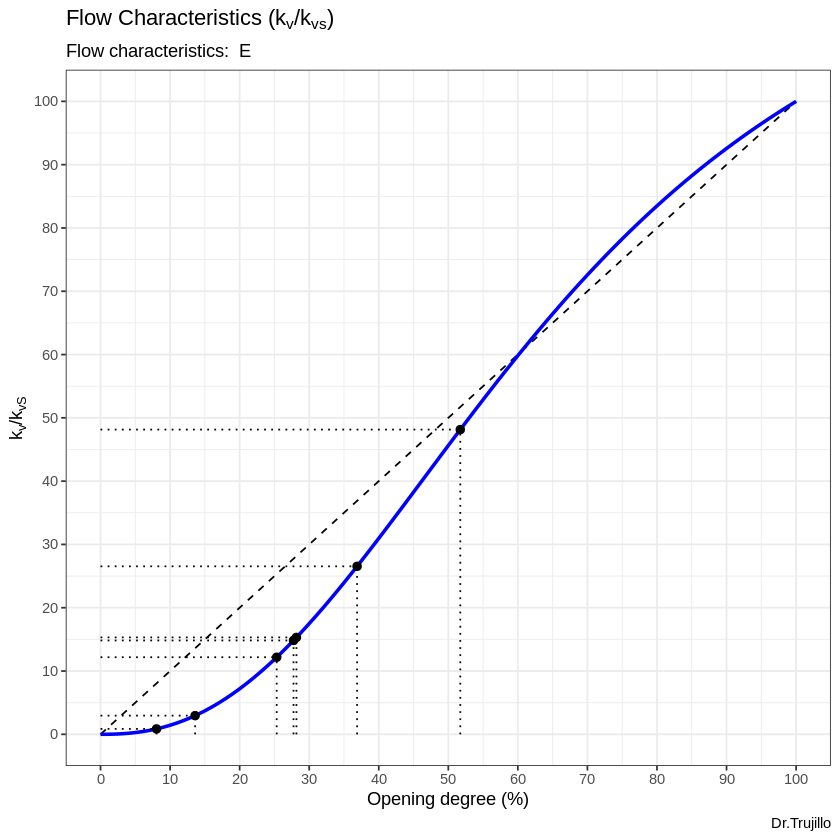

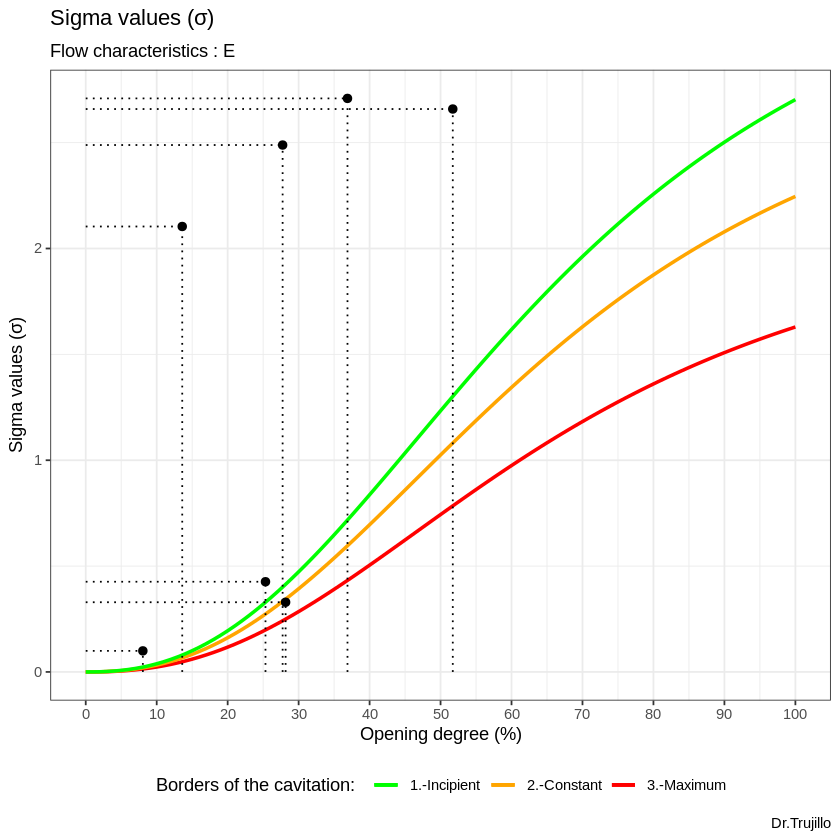

In [15]:
 i <- 1
 data_analyse %>%  tab_param_points(i)
 plot_kv_kvs2(data_analyse, i)
 plot_sigma2(data_analyse, i)

Second valve

Measurements,P1,P2,DP,Flow,Kv,Zeta,FLp/Fp,Kv/Kvs,Position,Sigma,Sigma_i,Sigma_c,Sigma_mv,Regime
Phase 2.1,1.6,1.24,0.36,"7,018","11,680",7.68,0.69,62.50%,63.95%,6.19,1.84,1.53,1.12,free of cavitation (regime I)
Phase 2.2,3.9,0.34,3.56,"7,018","3,714",75.94,0.86,19.88%,40.87%,0.37,0.58,0.49,0.36,choking cavitation (regime IV)
Phase 2.3,11.6,0.15,11.45,702,207,24420.34,0.99,1.11%,18.59%,0.10,0.03,0.03,0.02,free of cavitation (regime I)
Phase 1.1,1.7,1.14,0.56,"4,825","6,438",25.27,0.79,34.45%,49.13%,3.80,1.01,0.84,0.62,free of cavitation (regime I)
Phase 1.2,2.9,0.24,2.66,"4,825","2,954",120.04,0.88,15.81%,38.12%,0.46,0.46,0.39,0.28,incipient cavitation (regime II)
Optional 1,1.9,1.14,0.76,"3,140","3,597",80.97,0.86,19.25%,40.46%,2.80,0.57,0.47,0.35,free of cavitation (regime I)
Optional 2,2.0,1.04,0.96,702,715,2047.47,0.97,3.83%,25.71%,2.11,0.11,0.09,0.07,free of cavitation (regime I)


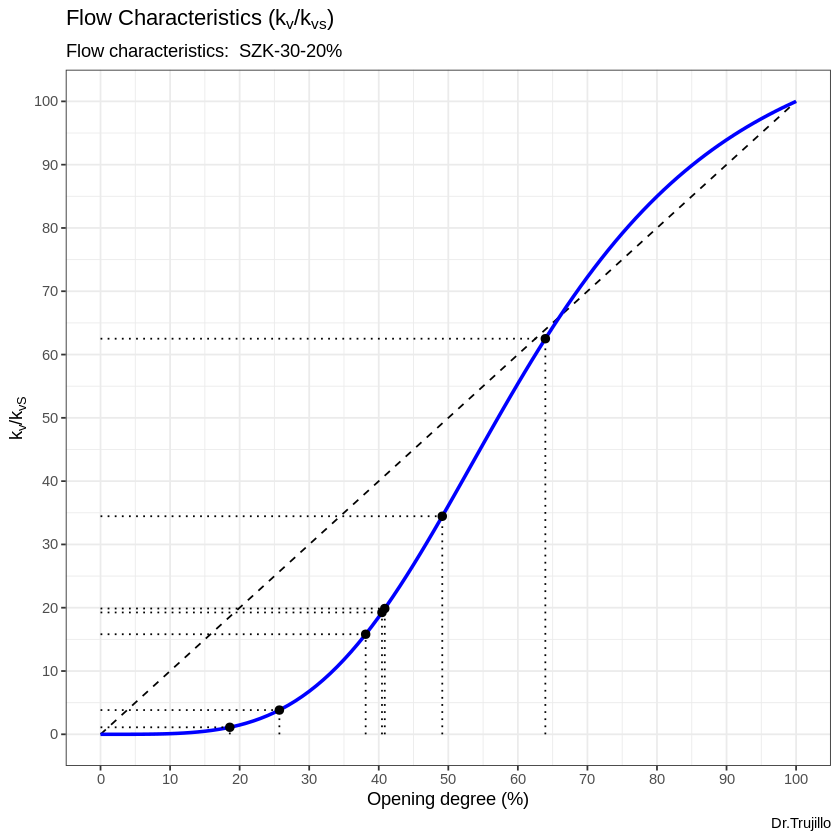

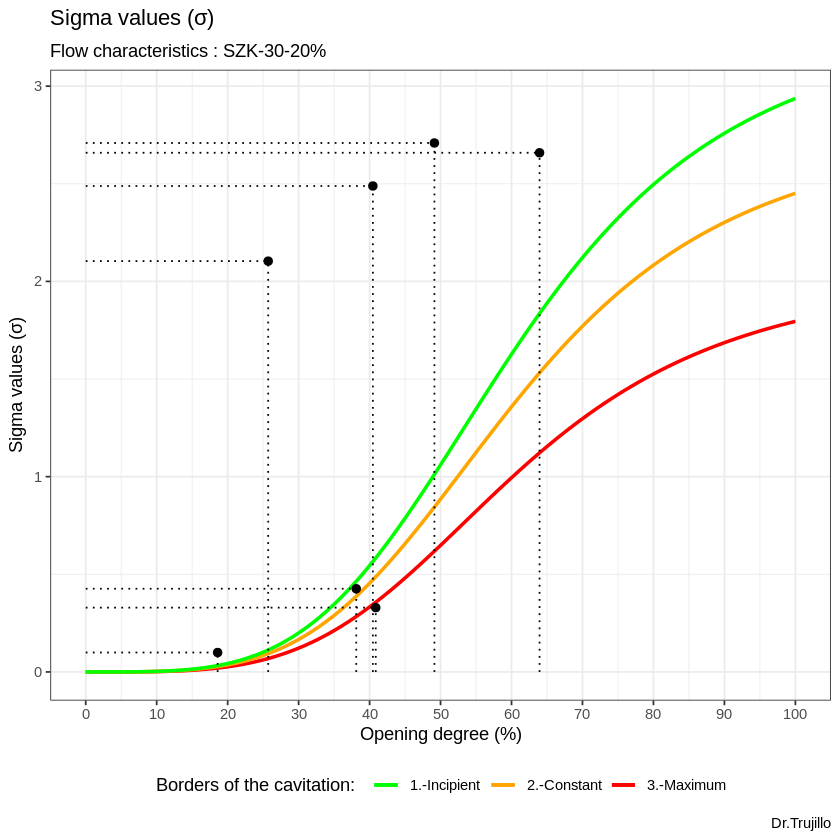

In [10]:
 i <- 2
 data_analyse %>%  tab_param_points(i)
 plot_kv_kvs2(data_analyse, i)
 plot_sigma2(data_analyse, i)